# Scatering Network for Seismology

This notebook reproduces the tutorials from the SCATSEISNET package.

Before you have to run ```1scatseisnet.py```.<br>
Before you start plotting the elbow curve and clustering, you have to run ```2elbow.py```.

In [3]:
import os
import io
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import numpy as np
import pandas as pd
import obspy
from obspy.clients.fdsn.client import Client
client = Client('IRIS')
from obspy import UTCDateTime
import datetime
import random
import sklearn
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans


In [4]:
# Create folder and define file path
os.makedirs('../output/scatseisnet/figure', exist_ok=True)
dirpath = '../output/scatseisnet/'


### Scattering network parameters

the number of octaves ( J, int) covered by the filter banks per layer. This defines the frequency range of analysis of the input data, from the Nyquist frequency fn down to fn/2^J , and should be decided according to the frequency range of interest for the task.

the resolution ( Q, int) represents the number of wavelets for each octave, so the frequency resolution of the filterbank. This should be large for the first layer (dense) and small for the other layers (sparse), as indicated in Andén and Mallat (2014).

the quality factor (float) is the ratio between the center frequency of every wavelet and the bandwidth. Because we work with constant-Q filters, this is defined from the entire filter bank. The lower the quality factor, the more redundant the information in the scattering coefficients. We suggest using a quality factor 1 at the first layer, and a larger at the remaining layers.

### Create scatnet

In the several papers on the topic, the authors have used the Gabor wavelet. In the packaged python script, they only offer the Morlet wavelet. We will try that out!

In [5]:
network = pd.read_pickle(dirpath+"data/scattering_network.pickle")
network

ScatteringNetwork(bins=3000, sampling_rate=50, len=2)
ComplexMorletBank(bins=3000, octaves=4, resolution=4, quality=1, sampling_rate=50, len=16)
ComplexMorletBank(bins=3000, octaves=5, resolution=2, quality=2, sampling_rate=50, len=10)

Visualize the filter bank

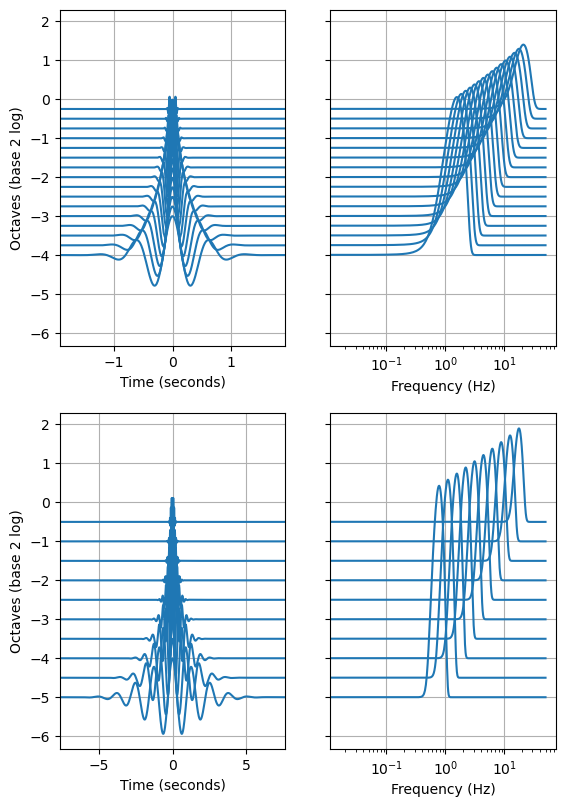

In [35]:
# Create axes (left for temporal, right for spectral domain)
fig, ax = plt.subplots(len(network.banks), 2, sharey=True, figsize=(6.4,4.8*2))

for i, bank in enumerate(network.banks):

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
        # Time domain
        ax[i, 0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[i, 1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of the largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[i, 0].set_ylabel("Octaves (base 2 log)")
    ax[i, 0].set_xlabel("Time (seconds)")
    ax[i, 0].set_xlim(-width_max, width_max)
    ax[i, 0].grid()
    ax[i, 1].set_xscale("log")
    ax[i, 1].set_xlabel("Frequency (Hz)")
    ax[i, 1].grid()

# # Save figure with index as part of the filename
plt.savefig(dirpath + 'figure/network.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
# Load data from file
with np.load(dirpath+"data/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]
    list_netstacha=data["list_netstacha"]
times.shape, order_1.shape,order_2.shape


((5759,), (5759, 3, 16), (5759, 3, 16, 10))

### Plot first order scattering coefficients

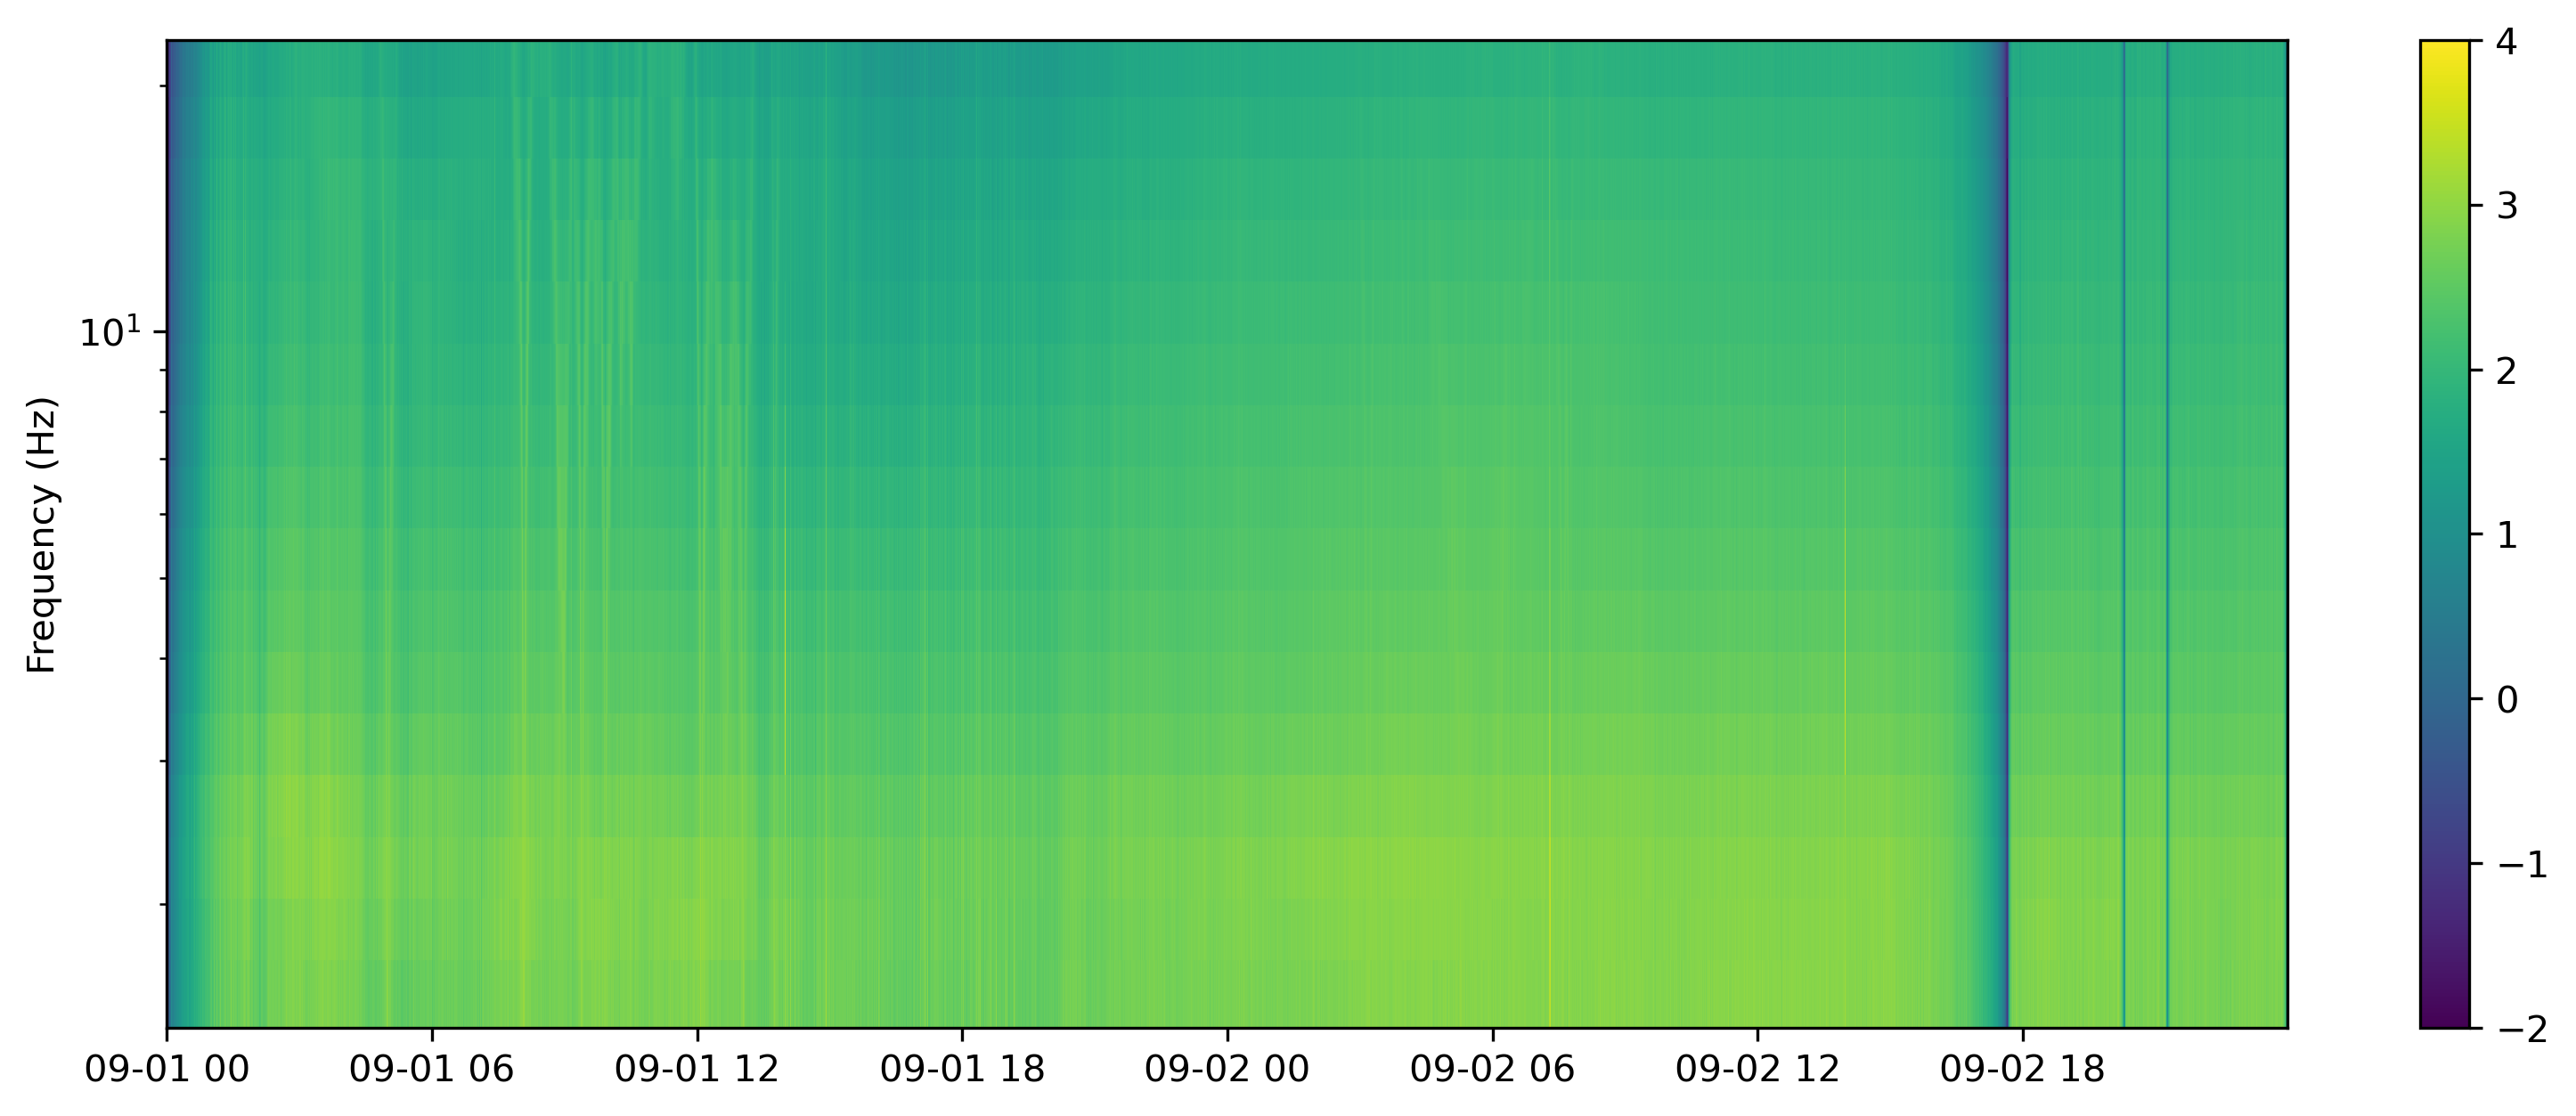

In [37]:
# Extract the first channel
channel_id = 1
timestamps = times.copy()
o_1 = np.log10(order_1[:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers
# Create figure and axes
fig, ax = plt.subplots(sharex=True, dpi=300, figsize=(6.4*2,4.8))

# First-order scattering coefficients
im = ax.pcolormesh(timestamps, center_frequencies, o_1.T, rasterized=True, vmin=-2,vmax=4)

# Axes labels
ax.set_yscale("log")
ax.set_ylabel("Frequency (Hz)")

fig.colorbar(im)
plt.savefig(dirpath+'figure/o1_scatcoefs.png', dpi=300, bbox_inches='tight')
plt.show()


## Reshape and stack scattering coefficients of all orders

In [38]:
# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))


Collected 5759 samples of 528 dimensions each.


## Dimensionality reduction

This tutorial uses FastICA for the dimensionality reduction, but we can try other things

In [10]:
model_latent = FastICA(n_components=5, whiten="unit-variance") #, random_state=42
features = model_latent.fit_transform(scattering_coefficients)


In [11]:
# Save the features
np.savez(
    dirpath+"data/independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open(dirpath+"data/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model_latent,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )
    

In [12]:
# Load features
features = np.load(dirpath+"data/independent_components.npz", allow_pickle=True)['features']
times = np.load(dirpath+"data/independent_components.npz", allow_pickle=True)['times']
print(features.shape,times.shape)
# Load the dimension reduction model
model_latent = pd.read_pickle(dirpath+"data/dimension_model.pickle")
model_latent


(5759, 5) (5759,)


FastICA(n_components=5)

Plots the features

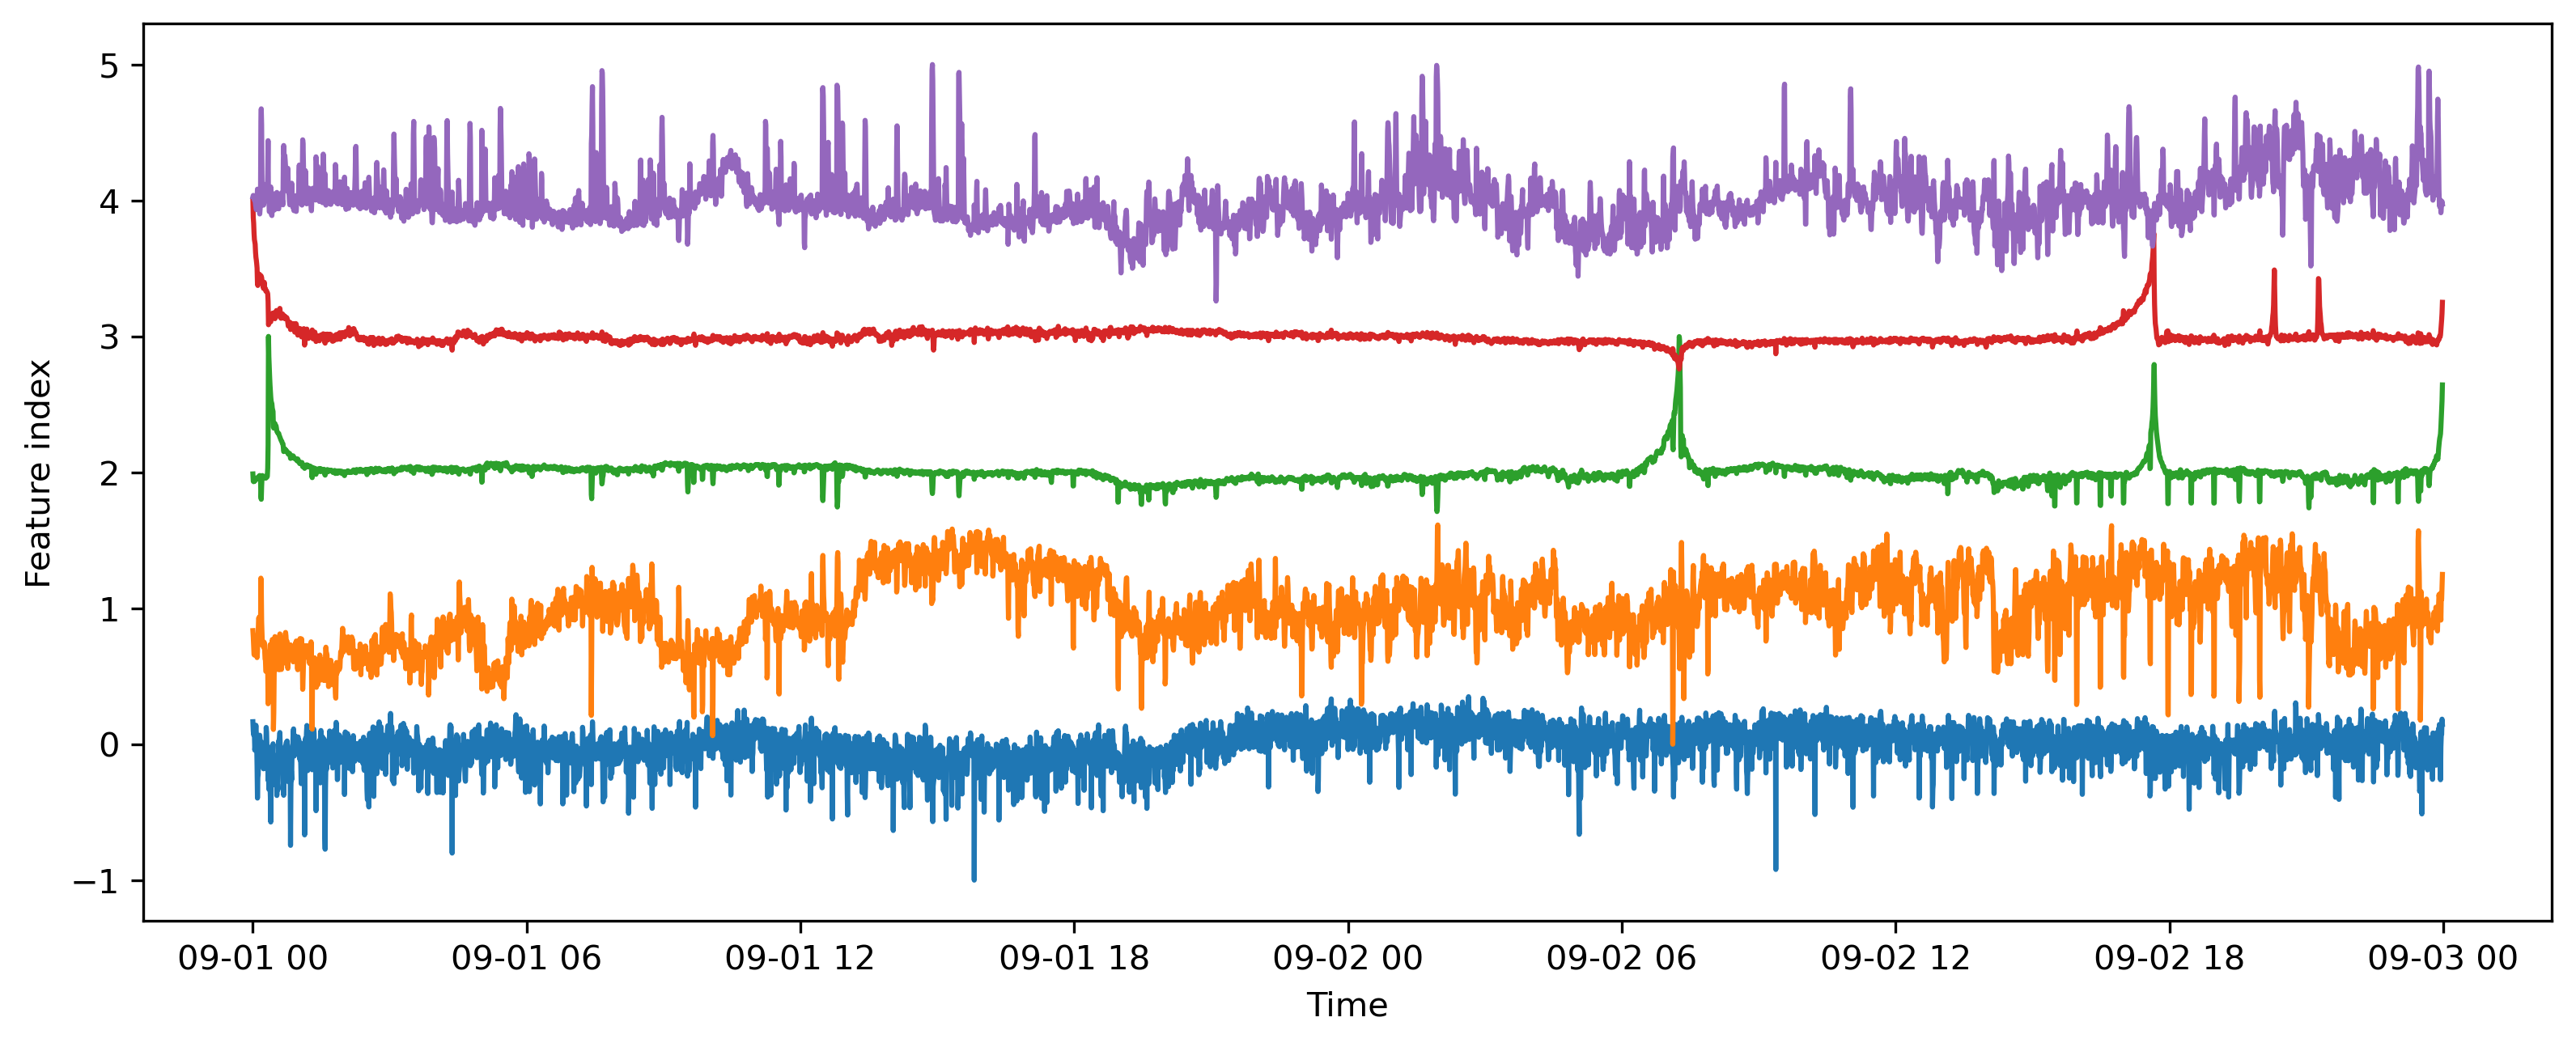

In [13]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=300, figsize=(6.4*2,4.8))
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Time")
plt.savefig(dirpath+'figure/features.png', dpi=300, bbox_inches='tight')
plt.show()


## Elbow curve
Start here after you have run ```2elbow.py```.<br>

In [16]:
sse = np.load(dirpath+"data/sse.npz", allow_pickle=True)['sse']
sse

array([28795.        , 24954.07845122, 22142.08851931, 19815.85650863,
       16269.43763083, 14830.04012309, 13863.63654164, 11858.06463924,
       11217.49228027, 10528.78959609, 10105.48946908,  9762.92941157,
        9406.99498061,  8962.50903486,  8563.29718256,  8249.51761229,
        7821.32170439,  7644.32132724,  7422.65545257,  7208.25445872])

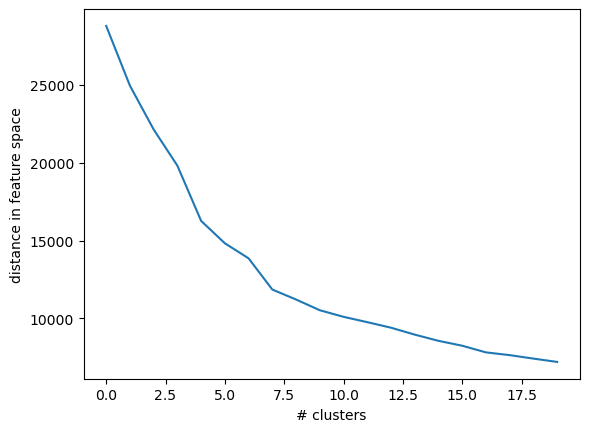

In [17]:
plt.plot(sse)
plt.xlabel('# clusters')
plt.ylabel('distance in feature space')
plt.savefig(dirpath+'figure/elbowl.png', dpi=300, bbox_inches='tight')


## Clustering
Set ```N_CLUSTERS``` equal the number of optimal clusters found useing the elbow curve.<br>
We will use Kmeans here.

In [18]:
N_CLUSTERS = 6 # optimal number found useing the elbow curve

# Perform clustering
model_cluster = KMeans(n_clusters=N_CLUSTERS, n_init='auto', random_state=4)
model_cluster.fit(features)

# Predict cluster for each sample
predictions = model_cluster.predict(features)
# Calculate centroids of clusters
centroids = np.abs(model_cluster.cluster_centers_)


In [19]:
# Save the prediction
np.savez(
    dirpath+"data/predictions_cl{}.npz".format(N_CLUSTERS),
    predictions=predictions,
)

# Save the centroids
np.savez(
    dirpath+"data/centroids_cl{}.npz".format(N_CLUSTERS),
    centroids=centroids,
)

### Cluster activity
Vizualize cluster-wise detection rate & waveforms.

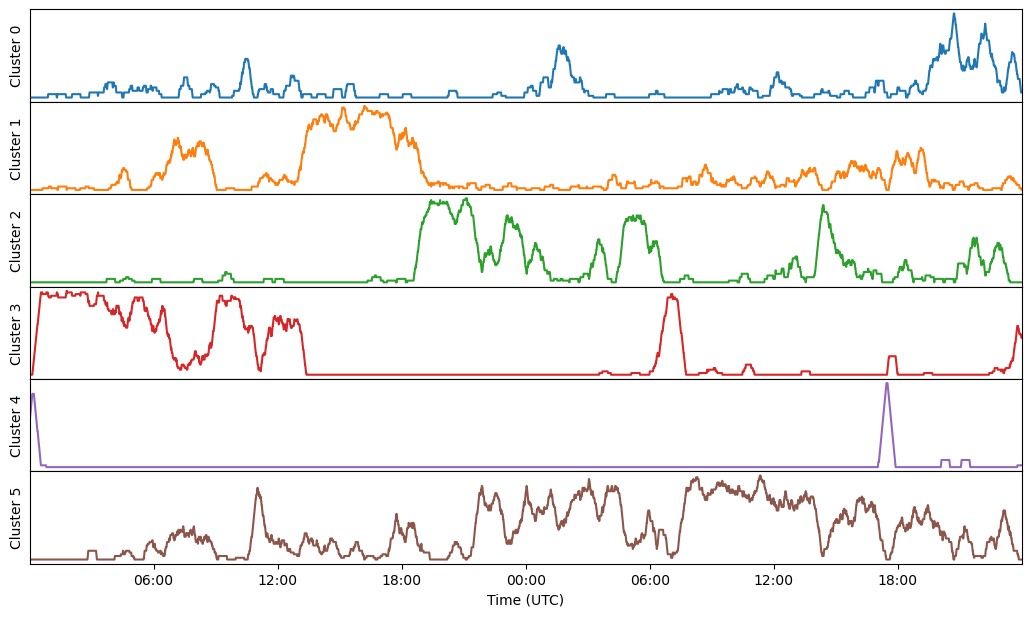

In [20]:
SMOOTH_KERNEL = 50

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(N_CLUSTERS,1,sharex=True,figsize=(6.4*2, 4.8*1.5))
fig.subplots_adjust(hspace=0)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax[i].plot(times, detection_rate, color="C{}".format(i))
        
    # Y-Label
    ax[i].set_yticks([])
    ax[i].set_ylabel("Cluster {}".format(i))

# X-Label
ax[i].set_xlabel("Time (UTC)")
ax[i].set_xlim(times[0],times[-1])
ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))

plt.savefig(dirpath+'figure/timeseries_cl{}.png'.format(N_CLUSTERS),
            dpi=300, bbox_inches='tight')
plt.show()


### Read waveforms & calculate distances

In [25]:
# read mseed file (produced with 1scatseisnet.py)
st_read = obspy.read(dirpath+"data/scattering_stream.mseed", format="MSEED")
st_read

3 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.080100Z | 50.0 Hz, 8640005 samples
UW.SHW..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.100100Z | 50.0 Hz, 8640006 samples
UW.HSR..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.060100Z | 50.0 Hz, 8640004 samples

In [26]:
st = obspy.Stream(st_read[0]) #select a trace (station)
st

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.080100Z | 50.0 Hz, 8640005 samples

In [27]:
N_WAVEFORMS = 20

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
means = list()
distances = list()
closests = list()

# for cluster in cl_list:
for cluster in np.unique(predictions):
    print('Cluster {}'.format(cluster))
    
    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:N_WAVEFORMS]]
    means.append(mean)
    distances.append(distance)
    closests.append(closest)

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = st.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces) # all waveforms from one station!!

distances_centroid = list()
for cent in centroids:
    distance_centroid = np.linalg.norm(features[predictions == cluster] - cent, axis=1)
    distances_centroid.append(distance_centroid)
    
np.savez(dirpath+"data/distances_cl{}.npz".format(N_CLUSTERS),
         means=np.asarray(means),
         distances=np.asarray(distances, dtype=object),
         closests=closests[0],
         distances_centroid=distances_centroid)
print('***DONE***')


Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
***DONE***


In [28]:
# load the means, closests (times), distances, distances_centroid
means = np.load(dirpath+"data/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['means']
closests = np.load(dirpath+"data/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['closests']
distances = np.load(dirpath+"data/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['distances']
distances_centroid = np.load(dirpath+"data/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['distances_centroid']


### Some statistics about the clusters

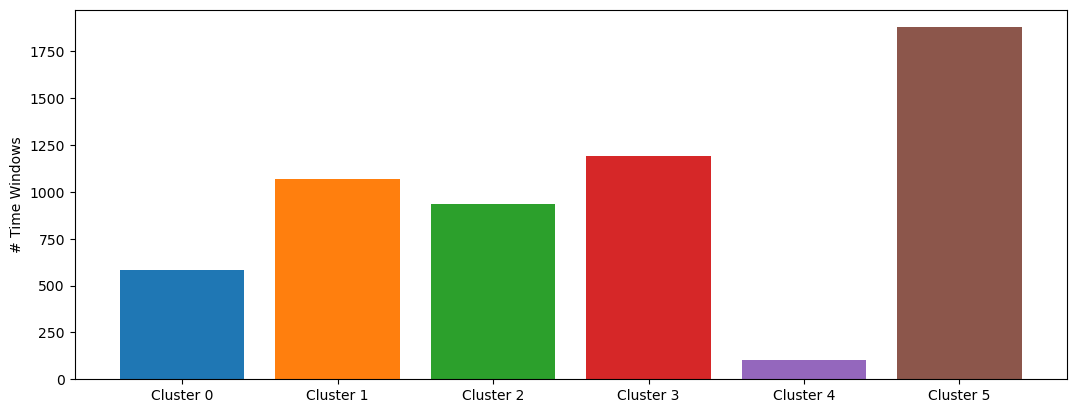

In [29]:
# plot the number of time windows in each cluster
plt.figure(figsize=(6.4*2,4.8))
for i, dist in enumerate(distances):
    plt.bar(i,dist.shape,color='C{}'.format(i))

plt.xticks(range(len(distances)), ['Cluster {}'.format(i) for i in range(len(distances))])
plt.ylabel('# Time Windows')
plt.savefig(dirpath+'figure/barplot_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')
plt.show()


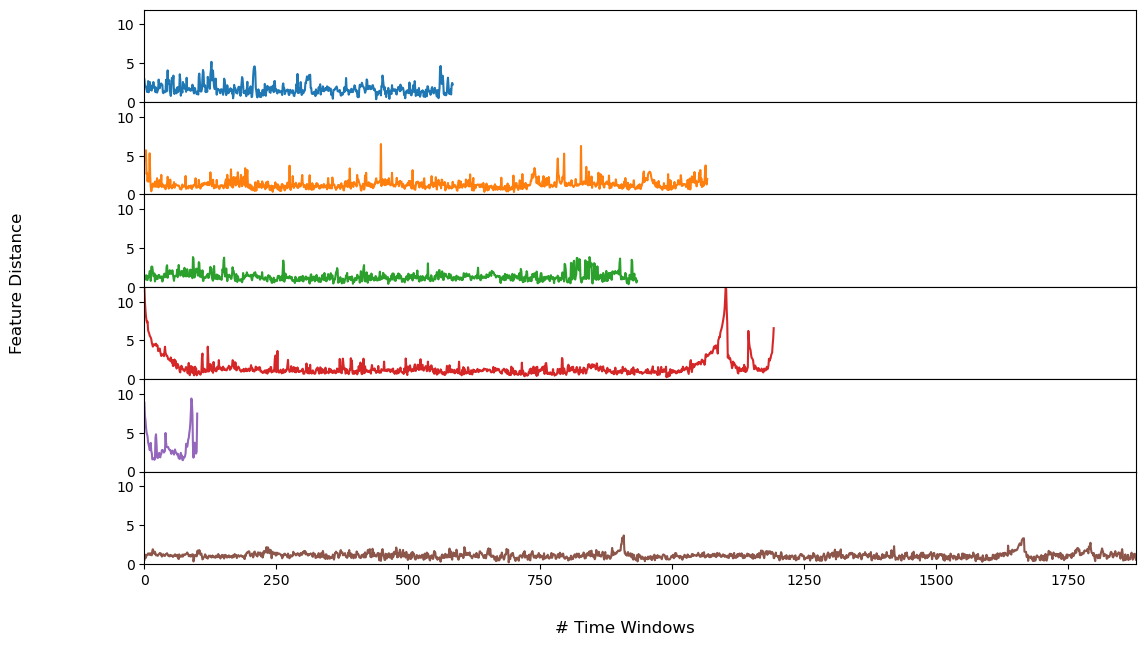

In [30]:
# plot distances of features for the different clusters
fig, ax = plt.subplots(N_CLUSTERS, 1,sharex=True,figsize=(6.4*2,4.8*1.5))#,constrained_layout=True
fig.subplots_adjust(hspace=0)
for i,dist in enumerate(distances):
    ax[i].plot(range(len(dist)),dist,color='C{}'.format(i))
    ax[i].set_xlim(0,len(max(distances, key=len)))
    ax[i].set_ylim(0,max(max(distances, key=tuple)))
fig.supylabel('Feature Distance')
fig.supxlabel("# Time Windows")
plt.savefig(dirpath+'figure/distance_features_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')
plt.show()


### Waveforms

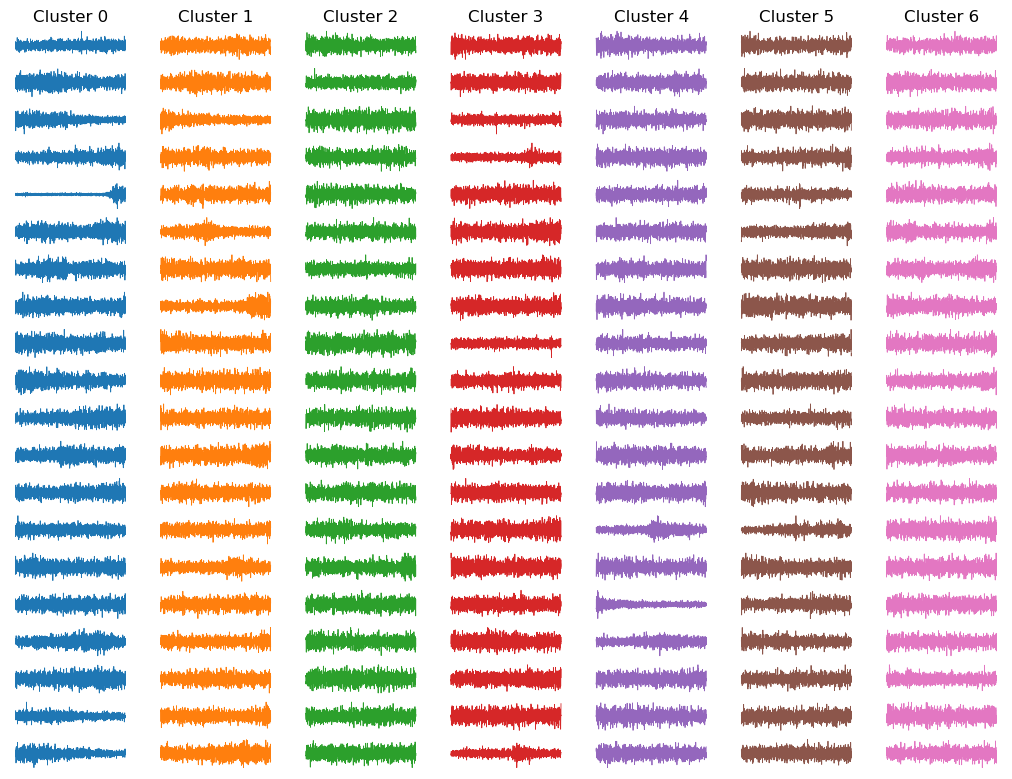

In [21]:
# Plot the results with NORMALIZATION
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, figsize=(6.4*2,4.8*2))

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms[:N_WAVEFORMS]):
    ax[0, i].set_title(f"Cluster {i}") #, rotation="vertical"
    for j, trace in enumerate(traces):
        trace_norm = trace.data /max(abs(trace.data))
        ax[j, i].plot(trace.times(), trace_norm, rasterized=True, lw=0.6, color='C{}'.format(i))
        ax[j, i].set_axis_off()

plt.savefig(dirpath+'figure/waveforms_norm_cl{}select_final.png'.format(N_CLUSTERS)
            , dpi=300, bbox_inches='tight')
plt.show()


### Spectrum

In [31]:
st_copy = st.copy()
stream = obspy.Stream()
for windowed_st in st_copy.slide(window_length=60.0, step=30.0):
    stream += windowed_st[0]
stream

5759 Trace(s) in Stream:

UW.EDM..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-01T00:01:00.000100Z | 50.0 Hz, 3001 samples
...
(5757 other traces)
...
UW.EDM..EHZ | 2004-09-02T23:59:00.000100Z - 2004-09-03T00:00:00.000100Z | 50.0 Hz, 3001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [32]:
cl_list = np.unique(predictions)
Pxx_dict = {}

tr = st[0]

fig, ax = plt.subplots()
for cl in np.unique(predictions):
    idx_select = predictions==cl
    times_select = times[idx_select]
    times_select = random.sample(times_select.tolist(), 10)

    NFFT=int(30*100)  # 30s * 100Hz
    Pxx_arr = np.full((len(times_select), int(NFFT/2.+1)), np.nan)  # do not hard-code
    
    for i, s_time in enumerate(times_select):
        print(i, end='\r')
        tr_slice = tr.slice(UTCDateTime(s_time), UTCDateTime(s_time+datetime.timedelta(seconds=30)))
        tr_slice.detrend('linear')
        Pxx, freqs = plt.psd(tr_slice.data, Fs=tr_slice.stats.sampling_rate, NFFT=int(NFFT))
        Pxx_arr[i,:] = Pxx
    Pxx_dict[cl] = Pxx_arr
    plt.close()

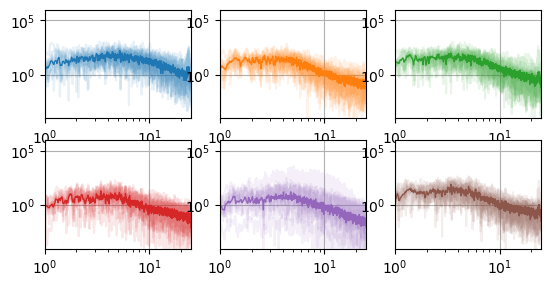

In [33]:
# set number of columns
ncols = len(cl_list)//2
# calculate number of rows
nrows = len(cl_list)-ncols

# loop through the length of tickers and keep track of index
for i, cl in enumerate(cl_list):
    Pxx_arr = Pxx_dict[cl]
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, i + 1)

    # filter df and plot ticker on the new subplot axis
    ax.plot(freqs, np.log10(Pxx_arr.T), color='C{}'.format(i), alpha=0.1)
    ax.plot(freqs, np.mean(np.log10(Pxx_arr), axis=0), color='C{}'.format(i), linewidth=1)
    
        # Format y-tick labels in scientific notation
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"10$^{{{int(x)}}}$"))

    # Set common formatting options for the subplot
    ax.set_xscale('log')
    ax.set_xlim(1, stream[0].stats.sampling_rate/2)
    ax.set_ylim(-4, 6)
    ax.grid()

fig.supxlabel('Frequency (Hz)')
fig.supylabel('Power Spectral Density (dB/Hz)')
plt.savefig(dirpath+'figure/psd_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')
plt.show()
